# GNN model items

### package install

In [1]:
# Environment Setup (note that capture silences the console output)
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

!git clone https://github.com/pmaldonado/cs224w-project-data.git

  ERROR: Command errored out with exit status 1:
   command: /accre/arch/easybuild/software/BinDist/Anaconda3/2022.05/bin/python -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-jl583xs5/torch-scatter_9ddeba0e1cce47be98fcaa3be3b01409/setup.py'"'"'; __file__='"'"'/tmp/pip-install-jl583xs5/torch-scatter_9ddeba0e1cce47be98fcaa3be3b01409/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-rsnnbknz
       cwd: /tmp/pip-install-jl583xs5/torch-scatter_9ddeba0e1cce47be98fcaa3be3b01409/
  Complete output (44 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.linux-x86_64-3.9
  creating build/lib.linux-x86_64-3.9/torch_scatter
  copying torch_scatter/placeholder.

  ERROR: Command errored out with exit status 1:
   command: /accre/arch/easybuild/software/BinDist/Anaconda3/2022.05/bin/python -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-71fwrmgg/torch-sparse_046507bcc8ca4f139a2abe2a10db77a8/setup.py'"'"'; __file__='"'"'/tmp/pip-install-71fwrmgg/torch-sparse_046507bcc8ca4f139a2abe2a10db77a8/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-d8mi97aj
       cwd: /tmp/pip-install-71fwrmgg/torch-sparse_046507bcc8ca4f139a2abe2a10db77a8/
  Complete output (67 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib.linux-x86_64-3.9
  creating build/lib.linux-x86_64-3.9/torch_sparse
  copying torch_sparse/select.py -> buil

Cloning into 'cs224w-project-data'...
remote: Enumerating objects: 53, done.
remote: Total 53 (delta 0), reused 0 (delta 0), pack-reused 53
Unpacking objects: 100% (53/53), done.


### import package

In [3]:
import random
import time
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree

from tqdm.notebook import tqdm
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp

In [4]:
# decide the running gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# read data

In [5]:
df = pd.read_csv('bonanza_buyer_item_seller_id_R_2.txt', sep='::', header=None, names=['buyer', 'item', 'seller', 'timestamp'])
train_data = df
df_train = df.groupby(['buyer','item']).count()
new_buyer = [index[0] for index in df_train.index]
new_item = [index[1] for index in df_train.index]
new_rating = [i for i in df_train.seller]

new_train_data_df = pd.DataFrame({'buyer_id':new_buyer,'item_id':new_item,'rating': new_rating})
new_train_data_df.head(5)

/tmp/ipykernel_15295/1907627779.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('bonanza_buyer_item_seller_id_R_2.txt', sep='::', header=None, names=['buyer', 'item', 'seller', 'timestamp'])


,buyer_id,item_id,rating
0,0,0,4
1,0,2,1
2,1,0,2
3,1,4,1
4,2,0,1


In [6]:
df = new_train_data_df[new_train_data_df['rating']>0]
print(len(df))

24882


In [7]:
print("Rating Distribution")
df.groupby(['rating'])['rating'].count()

Rating Distribution


rating
1     17975
2      4133
3      1445
4       552
5       249
6       155
7       101
8        62
9        45
10       38
11       28
12       21
13       13
14       14
15        8
16        4
17        5
18        3
19        4
20        4
21        2
22        4
25        5
27        1
29        2
30        1
32        1
33        1
36        1
40        1
52        1
56        1
60        1
70        1
Name: rating, dtype: int64

In [8]:
#train，test split 0.2，0.8
train, test = train_test_split(df.values, test_size=0.2, random_state=16)
train_df = pd.DataFrame(train, columns=df.columns)
test_df = pd.DataFrame(test, columns=df.columns)

In [9]:
# transform the labels
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
train_df['buyer_id_idx'] = le_user.fit_transform(train_df['buyer_id'].values)
train_df['item_id_idx'] = le_item.fit_transform(train_df['item_id'].values)

In [13]:
# get the id set 
train_user_ids = train_df['buyer_id'].unique()
train_item_ids = train_df['item_id'].unique()

print(len(train_user_ids), len(train_item_ids))

test_df = test_df[
  (test_df['buyer_id'].isin(train_user_ids)) & \
  (test_df['item_id'].isin(train_item_ids))
]
print(len(test))

7949 2864
4977


In [14]:
test_df['buyer_id_idx'] = le_user.transform(test_df['buyer_id'].values)
test_df['item_id_idx'] = le_item.transform(test_df['item_id'].values)

In [15]:
# check the number of data
n_users = train_df['buyer_id_idx'].nunique()
n_items = train_df['item_id_idx'].nunique()
print("Number of Unique Buyers : ", n_users)
print("Number of unique Items : ", n_items)

Number of Unique Buyers :  7949
Number of unique Items :  2864


In [16]:
def data_loader(data, batch_size, n_usr, n_itm):
# check the negtive samples
    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id
            
    # get the users set with the negtive ids

    interected_items_df = data.groupby('buyer_id_idx')['item_id_idx'].apply(list).reset_index()
    indices = [x for x in range(n_usr)]
    
   # split the data into batches

    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)
    users.sort()
    users_df = pd.DataFrame(users,columns = ['buyers'])
    
    # get the positive id and begtive ids

    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'buyer_id_idx', right_on = 'buyers')
    pos_items = interected_items_df['item_id_idx'].apply(lambda x : random.choice(x)).values
    neg_items = interected_items_df['item_id_idx'].apply(lambda x: sample_neg(x)).values

    return (
        torch.LongTensor(list(users)).to(device), 
        torch.LongTensor(list(pos_items)).to(device) + n_usr, 
        torch.LongTensor(list(neg_items)).to(device) + n_usr
    )

data_loader(train_df, 16, n_users, n_items)

(tensor([   5,   95,  543, 1506, 1740, 2867, 3639, 4034, 4290, 4464, 5146, 5269,
         5579, 7600, 7703, 7781], device='cuda:0'),
 tensor([ 7949,  8613,  9334,  8105,  8706,  8194,  8463,  8638,  8734,  8825,
          9077,  9102, 10177, 10468, 10152, 10303], device='cuda:0'),
 tensor([10016,  9248, 10812,  8971, 10587,  9417,  8923,  9153,  8661, 10164,
         10469,  8670,  8461, 10696,  8017, 10260], device='cuda:0'))

In [12]:
# turn the ids into tensors
u_t = torch.LongTensor(train_df.buyer_id_idx)
i_t = torch.LongTensor(train_df.item_id_idx) + n_users

train_edge_index = torch.stack((
  torch.cat([u_t, i_t]),
  torch.cat([i_t, u_t])
)).to(device)
train_edge_index

tensor([[ 6088,  6050,  5746,  ...,  9226,  9840,  8563],
        [ 9583, 10383,  9732,  ...,   280,  4093,   865]], device='cuda:0')

In [13]:
train_edge_index[:,-1], train_edge_index[:, 0]

(tensor([8563,  865], device='cuda:0'), tensor([6088, 9583], device='cuda:0'))

In [14]:
train_edge_index[:, len(train)-1], train_edge_index[:, len(train)]

(tensor([ 865, 8563], device='cuda:0'), tensor([9583, 6088], device='cuda:0'))

In [15]:
# Build LightGCN
class LightGCNConv(MessagePassing):
  def __init__(self, **kwargs):  
    super().__init__(aggr='add')

  def forward(self, x, edge_index):
    # Compute normalization
    from_, to_ = edge_index
    deg = degree(to_, x.size(0), dtype=x.dtype)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    norm = deg_invaadad_sqrt[from_] * deg_inv_sqrt[to_]

    # Start propagating messages (no update after aggregation)
    return self.propagate(edge_index, x=x, norm=norm)

  def message(self, x_j, norm):
    return norm.view(-1, 1) * x_j

In [16]:
test_x = torch.Tensor(np.eye(5))
test_edge_index = torch.LongTensor(np.array([
  [0, 0, 1, 1, 2, 3, 3, 4],
  [2, 3, 3, 4, 0, 0, 1, 1]
]))

LightGCNConv()(test_x, test_edge_index)

tensor([[0.0000, 0.0000, 0.7071, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.5000, 0.7071],
        [0.7071, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.7071, 0.0000, 0.0000, 0.0000]])

In [17]:
# build the NGCF. model
class NGCFConv(MessagePassing):
  def __init__(self, latent_dim, dropout, bias=True, **kwargs):  
    super(NGCFConv, self).__init__(aggr='add', **kwargs)

    self.dropout = dropout

    self.lin_1 = nn.Linear(latent_dim, latent_dim, bias=bias)
    self.lin_2 = nn.Linear(latent_dim, latent_dim, bias=bias)

    self.init_parameters()


  def init_parameters(self):
    nn.init.xavier_uniform_(self.lin_1.weight)
    nn.init.xavier_uniform_(self.lin_2.weight)


  def forward(self, x, edge_index):
    # Compute normalization
    from_, to_ = edge_index
    deg = degree(to_, x.size(0), dtype=x.dtype)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

    # Start propagating messages
    out = self.propagate(edge_index, x=(x, x), norm=norm)

    # Perform update after aggregation
    out += self.lin_1(x)
    out = F.dropout(out, self.dropout, self.training)
    return F.leaky_relu(out)


  def message(self, x_j, x_i, norm):
    return norm.view(-1, 1) * (self.lin_1(x_j) + self.lin_2(x_j * x_i))

In [18]:
# develop the GNN model
class RecSysGNN(nn.Module):
  def __init__(
      self,
      latent_dim, 
      num_layers,
      num_users,
      num_items,
      model, 
      dropout=0.1
  ):
    super(RecSysGNN, self).__init__()

    assert (model == 'NGCF' or model == 'LightGCN'), \
        'Model must be NGCF or LightGCN'
    self.model = model
    self.embedding = nn.Embedding(num_users + num_items, latent_dim)

    if self.model == 'NGCF':
      self.convs = nn.ModuleList(
        NGCFConv(latent_dim, dropout=dropout) for _ in range(num_layers)
      )
    else:
      self.convs = nn.ModuleList(LightGCNConv() for _ in range(num_layers))

    self.init_parameters()

# if the model is the NGCF，
  def init_parameters(self):
    if self.model == 'NGCF':
      nn.init.xavier_uniform_(self.embedding.weight, gain=1)
    else:
      # Authors of LightGCN report higher results with normal initialization
      nn.init.normal_(self.embedding.weight, std=0.1) 


  def forward(self, edge_index):
    emb0 = self.embedding.weight
    embs = [emb0]

    emb = emb0
    for conv in self.convs:
      emb = conv(x=emb, edge_index=edge_index)
      embs.append(emb)

    out = (
      torch.cat(embs, dim=-1) if self.model == 'NGCF' 
      else torch.mean(torch.stack(embs, dim=0), dim=0)
    )
    
    return emb0, out


  def encode_minibatch(self, users, pos_items, neg_items, edge_index):
    emb0, out = self(edge_index)
    return (
        out[users], 
        out[pos_items], 
        out[neg_items], 
        emb0[users],
        emb0[pos_items],
        emb0[neg_items]
    )

In [19]:
def compute_bpr_loss(users, users_emb, pos_emb, neg_emb, user_emb0,  pos_emb0, neg_emb0):
  # compute loss from initial embeddings, used for regulization
  reg_loss = (1 / 2) * (
    user_emb0.norm().pow(2) + 
    pos_emb0.norm().pow(2)  +
    neg_emb0.norm().pow(2)
  ) / float(len(users))
  
  # compute BPR loss from user, positive item, and negative item embeddings
  pos_scores = torch.mul(users_emb, pos_emb).sum(dim=1)
  neg_scores = torch.mul(users_emb, neg_emb).sum(dim=1)
      
  bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))
      
  return bpr_loss, reg_loss

In [20]:
# Calculate the  precision and the recall
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):
  test_user_ids = torch.LongTensor(test_data['buyer_id_idx'].unique())
  # compute the score of all user-item pairs
  relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts,0, 1))

  # create dense tensor of all user-item interactions
  i = torch.stack((
    torch.LongTensor(train_df['buyer_id_idx'].values),
    torch.LongTensor(train_df['item_id_idx'].values)
  ))
  v = torch.ones((len(train_df)), dtype=torch.float64)
  interactions_t = torch.sparse.FloatTensor(i, v, (n_users, n_items))\
      .to_dense().to(device)
  
  # mask out training user-item interactions from metric computation
  relevance_score = torch.mul(relevance_score, (1 - interactions_t))

  # compute top scoring items for each user
  topk_relevance_indices = torch.topk(relevance_score, K).indices
  topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.cpu().numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])
  topk_relevance_indices_df['buyer_ID'] = topk_relevance_indices_df.index
  topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
  topk_relevance_indices_df = topk_relevance_indices_df[['buyer_ID','top_rlvnt_itm']]

  # measure overlap between recommended (top-scoring) and held-out user-item 
  # interactions
  test_interacted_items = test_data.groupby('buyer_id_idx')['item_id_idx'].apply(list).reset_index()
  metrics_df = pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'buyer_id_idx',right_on = ['buyer_ID'])
  metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.item_id_idx, metrics_df.top_rlvnt_itm)]

  metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['item_id_idx']), axis = 1) 
  metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)

  return metrics_df['recall'].mean(), metrics_df['precision'].mean()

In [21]:
# training setting
latent_dim = 64
n_layers = 3 

EPOCHS = 50
BATCH_SIZE = 1024
DECAY = 0.0001
LR = 0.005 
K = 5

In [22]:
# define training process
def train_and_eval(model, optimizer, train_df):
  loss_list_epoch = []
  bpr_loss_list_epoch = []
  reg_loss_list_epoch = []

  recall_list = []
  precision_list = []

  for epoch in tqdm(range(EPOCHS)):
      n_batch = int(len(train)/BATCH_SIZE)
    
      final_loss_list = []
      bpr_loss_list = []
      reg_loss_list = []
    
      model.train()
      for batch_idx in range(n_batch):

          optimizer.zero_grad()

          users, pos_items, neg_items = data_loader(train_df, BATCH_SIZE, n_users, n_items)
          users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = model.encode_minibatch(users, pos_items, neg_items, train_edge_index)

          bpr_loss, reg_loss = compute_bpr_loss(
            users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0
          )
          reg_loss = DECAY * reg_loss
          final_loss = bpr_loss + reg_loss

          final_loss.backward()
          optimizer.step()

          final_loss_list.append(final_loss.item())
          bpr_loss_list.append(bpr_loss.item())
          reg_loss_list.append(reg_loss.item())

      model.eval()
      with torch.no_grad():
          _, out = model(train_edge_index)
          final_user_Embed, final_item_Embed = torch.split(out, (n_users, n_items))
          test_topK_recall,  test_topK_precision = get_metrics(
            final_user_Embed, final_item_Embed, n_users, n_items, train_df, test_df, K
          )

      loss_list_epoch.append(round(np.mean(final_loss_list),4))
      bpr_loss_list_epoch.append(round(np.mean(bpr_loss_list),4))
      reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

      recall_list.append(round(test_topK_recall,4))
      precision_list.append(round(test_topK_precision,4))

  return (
    loss_list_epoch, 
    bpr_loss_list_epoch, 
    reg_loss_list_epoch, 
    recall_list, 
    precision_list
  )

In [23]:
# LightGCN training
lightgcn = RecSysGNN(
  latent_dim=latent_dim, 
  num_layers=n_layers,
  num_users=n_users,
  num_items=n_items,
  model='LightGCN'
)
lightgcn.to(device)

optimizer = torch.optim.Adam(lightgcn.parameters(), lr=LR)
print("Size of Learnable Embedding : ", [x.shape for x in list(lightgcn.parameters())])

Size of Learnable Embedding :  [torch.Size([10813, 64])]


In [24]:
light_loss, light_bpr, light_reg, light_recall, light_precision = train_and_eval(lightgcn, optimizer, train_df)

  0%|          | 0/50 [00:00<?, ?it/s]

In [25]:
epoch_list = [(i+1) for i in range(EPOCHS)]

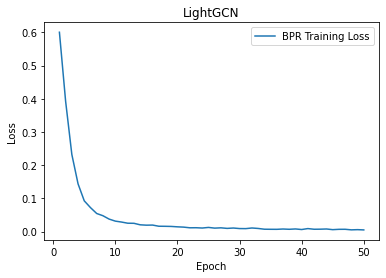

In [26]:
# Plot the leanring curve of LightGCN
plt.plot(epoch_list, light_bpr, label='BPR Training Loss')


plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LightGCN')
plt.legend()

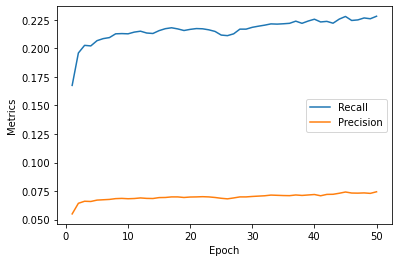

In [27]:
# Plot recall and precision with GCN
plt.plot(epoch_list, light_recall, label='Recall')
plt.plot(epoch_list, light_precision, label='Precision')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

In [28]:
#NGCF training
ngcf = RecSysGNN(
  latent_dim=latent_dim, 
  num_layers=n_layers,
  num_users=n_users,
  num_items=n_items,
  model='NGCF'
)
ngcf.to(device)

optimizer = torch.optim.Adam(ngcf.parameters(), lr=LR)
print("Size of Learnable Embedding : ", [x.shape for x in list(ngcf.parameters())])

Size of Learnable Embedding :  [torch.Size([10813, 64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64])]


In [29]:
ngcf_loss, ngcf_bpr, ngcf_reg, ngcf_recall, ngcf_precision = train_and_eval(ngcf, optimizer, train_df)

  0%|          | 0/50 [00:00<?, ?it/s]

In [30]:
epoch_list = [(i+1) for i in range(EPOCHS)]

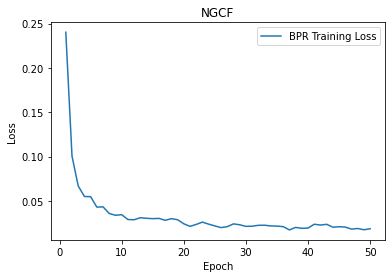

In [31]:
# Plot training curve
plt.plot(epoch_list, ngcf_bpr, label='BPR Training Loss')


plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('NGCF')
plt.legend()

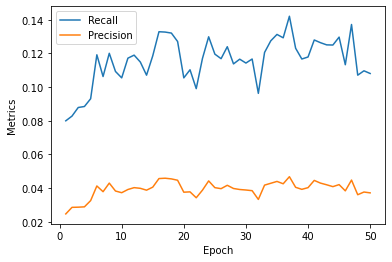

In [32]:
# Plot evaluation and recall of NGCF
plt.plot(epoch_list, ngcf_recall, label='Recall')
plt.plot(epoch_list, ngcf_precision, label='Precision')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

In [33]:
# Compare the max precision of the two models. 
max(light_precision), max(light_recall)

(0.0744, 0.2282)

In [34]:
max(ngcf_precision), max(ngcf_recall)

(0.0468, 0.1421)